In [43]:
:ext TypeSynonymInstances
:ext FlexibleInstances

In [44]:
import Utils
import Data.Tuple.Extra (uncurry3, both, first, second, (***))
import Data.Bool (bool)
import Data.List.Extra (sortOn, dropEnd)
import Data.Ord (Down(..))
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad (replicateM, liftM2)
import Control.Monad.Trans.State
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [45]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate
import qualified System.Random.MWC.Probability as MWC
-- import Tyche.Inference.LikelihoodWeighting

In [46]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

# Setting Things Up

## The Model

Worlds are distinguished only by the height of the individual at issue (call him John)

In [47]:
data World = World {label :: String, ht :: Int} deriving Eq

instance Ord World where
  w <= w' = ht w <= ht w'

instance Show World where
  show (World l _) = l

But what we reason about are effectively **pointed distributions**, which include information about John's height *relative to other heights of individuals in the comparison class*

A **proposition** is a set of these centered distributions

In [48]:
type Prop = [World]

For the sake of computational efficiency, we imagine that there are only 11 possible heights

In [49]:
heights = [1 .. 11]
universe = [World ("j" ++ show h) h | h <- heights]

Again for efficiency's sake, not all world-center pairs are considered possible. The median height is assumed to fall between $4$ and $8$, and John's height is assumed to fall within $3$ steps of the median: 

\begin{equation} C_{\textsf{j}} \subseteq \Bigl\{\langle w, \mu\rangle \Bigm\vert 4 \leq \mu \leq 8,\ -3 \leq \mu - \textsf{ht}_{w}(\textsf{j}) \leq 3\Bigr\} \end{equation}

In [50]:
sigma = 3
ccs = drop sigma . dropEnd sigma $ heights

## The Language

We have a marked utterance, an unmarked utterance, and a null utterance (the least marked)

In [51]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances = [minBound .. maxBound]

A **lexicon** is a denotation function mapping utterances to propositions

In [52]:
data Lexicon = Lex {lexID :: (Int,Int), den :: Utt -> Prop}
instance Show Lexicon where
  show (Lex _ f) = "C = " ++ show (f UNone) ++ "; E = " ++ show (f UTall)
instance Eq Lexicon where
  (Lex m _) == (Lex n _) = m == n
instance Ord Lexicon where
  (Lex m _) <= (Lex n _) = m <= n

## Rational Agents

In [94]:
-- Initialize reference cell for storing results to share within and between computations
type Cache = IORef (Int, Map.Map (Int, Utt, Int) (Dist World))
cacheRefTall <- newIORef (0, Map.empty) :: IO Cache
cacheRefShrt <- newIORef (0, Map.empty) :: IO Cache
cacheRefNone <- newIORef (0, Map.empty) :: IO Cache

An $n$-level agent reasoning about `a` given `k` is a graphical model (supplemented with a memory, for efficiency)
- if the problem is old, the posterior distribution is returned from memory
- if the problem is new, then priors over indices, messages, and lexica are fed to a node computing the posterior distribution over `a`

In [82]:
data Priors = Priors {wp :: Int -> Model World, up :: Model Utt, cp :: Model Int, lp :: Int -> Model Lexicon}
type Agent k a = Priors -> Cache -> (Int, k, Int) -> Model a
type AgentPlain k a = Priors -> (Int, k, Int) -> Model a

* A speaker trying to describe index $i$ is an agent that chooses an utterance $u$ in proportion to its prior probability (its cost) and the likelihood that a listener would assign to $i$ upon hearing $u$
* A listener trying to interpret an utterance $u$ is an agent that chooses an index $i$ in proportion to its prior probability and the likelihood that a speaker would assign to $u$ upon trying to describe $i$

In [83]:
{--
speakerPlain :: AgentPlain Index Utt
speakerPlain priors (n,i,l) =
  do u   <- up priors
     lnr <- lift $ enumD $ listenerPlain priors (n-1,u,l)
     weight $ alpha * logProb lnr i
     return u

listenerPlain :: AgentPlain Utt Index
listenerPlain priors (n,u,l)
  | n > 0 =
      do index  <- ip priors
         interp <- if n == 1 then lp priors else return l
         spr    <- lift . enumD $ speakerPlain priors (n,index,interp)
         observe spr u
         return index
  | otherwise =
      do index <- ip priors
         condition (index `elem` den l u)
         return index
--}

In [84]:
alpha, lambda :: Double
alpha = 4
lambda = 4

utility :: Lexicon -> Model World -> IO Double
utility l worldPrior = sum <$> traverse (\w -> liftM2 (*) (p w) (d w)) universe
  where
    d w = exp . flip logProb w <$> enumD worldPrior
    p w | w `elem` den l UTall = exp . flip logProb w <$>
            enumD (worldPrior >>= \w' -> condition (w' `elem` den l UTall) >> return w')
        | w `elem` den l UShrt = exp . flip logProb w <$>
            enumD (worldPrior >>= \w' -> condition (w' `elem` den l UShrt) >> return w')
        | otherwise            = exp . flip logProb w <$>
            enumD worldPrior

speaker :: Agent World Utt
speaker priors ref (n,w,mu)
  | n == 1 =
      do u <- up priors
         l <- lp priors mu
         condition (w `elem` den l u)
         return u
  | otherwise =
      do u <- up priors
         lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,mu)
         weight $ alpha * logProb lnr w
         return u

listener :: Agent Utt (World, Int)
listener priors ref (n,u,mu) =
   do cc     <- if n == 1 then cp priors else return mu
      world  <- wp priors cc
      spr    <- lift . enumD $ speaker priors ref (n,world,cc)
      observe spr u
      return (world, cc)

In [87]:
ccPriorFlat :: Model Int
ccPriorFlat = unif ccs

worldPriorNormal :: Int -> Model World
worldPriorNormal mu = 
  do let plaus = [mu - sigma .. mu + sigma]
         cands = filter (\w -> ht w `elem` plaus) universe
     w <- unif [w' | w' <- universe, abs (ht w' - mu) <= sigma]
     observe (Normal 0 1.85) (fromIntegral $ ht w - mu)
     return w
     
lexPriorPos :: (Int -> Model World) -> Int -> Model Lexicon
lexPriorPos genWorldModel mu =
  do let plaus = [mu - sigma .. mu + sigma]
         cands = filter (\w -> ht w `elem` plaus) universe
     (t,s) <- unif [(t,s) | t <- plaus, s <- plaus, t >= s]
     let f UNone = cands
         f UTall = filter (\w -> ht w >= t) cands
         f UShrt = filter (\w -> ht w <= s) cands
     ut <- lift $ utility (Lex (t,s) f) (genWorldModel mu)
     weight $ lambda * ut
     return (Lex (t,s) f)

In [88]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

utterancePrior1 :: Model Utt
utterancePrior1 = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

In [92]:
infoQFBaseline = Priors worldPriorNormal utterancePrior1 ccPriorFlat (lexPriorPos worldPriorNormal)
infoQFPos = infoQFBaseline

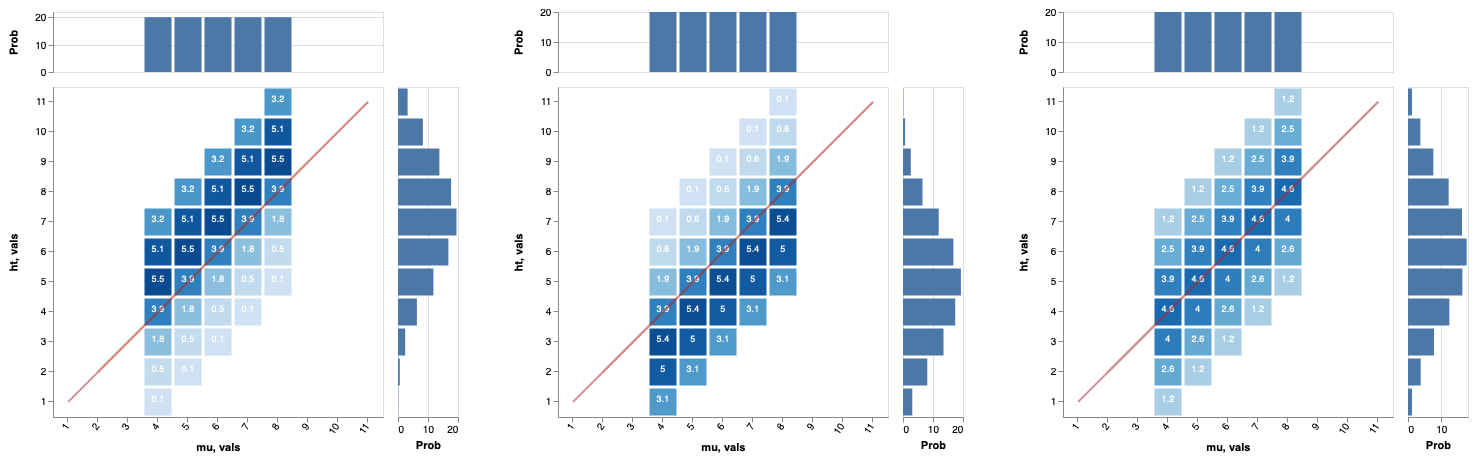

In [95]:
writeIORef cacheRefTall (0, Map.empty)
writeIORef cacheRefShrt (0, Map.empty)
writeIORef cacheRefNone (0, Map.empty)

mkGraph m = do
  heat <- enumD (first ht <$> m)
  return $ margHeatFromDist heat
--   bar  <- enumD (lexID    . snd <$> m)
--   return $ toVegaLite
--     [ center True
--     , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
--     ]
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoQFPos cacheRefTall (1, UTall, 6)
  , listener infoQFPos cacheRefShrt (1, UShrt, 6)
  , listener infoQFPos cacheRefNone (1, UNone, 6)
  ]

In [91]:
lexPriorDem :: (Int -> Model World) -> Int -> Model Lexicon
lexPriorDem genWorldModel mu =
  do let plaus = [mu - sigma .. mu + sigma]
         cands = filter (\w -> ht w `elem` plaus) universe
     (t,s) <- unif [(t,s) | t <- plaus, s <- plaus, t >= s]
     let f UNone = cands
         f UTall = filter (\w -> 6 >= t && ht w == 6) cands
         f UShrt = filter (\w -> 6 <= s && ht w == 6) cands
     ut <- lift $ utility (Lex (t,s) f) (genWorldModel mu)
     weight $ lambda * ut
     return (Lex (t,s) f)

In [93]:
infoQFDem = infoQFBaseline {lp = lexPriorDem worldPriorNormal}

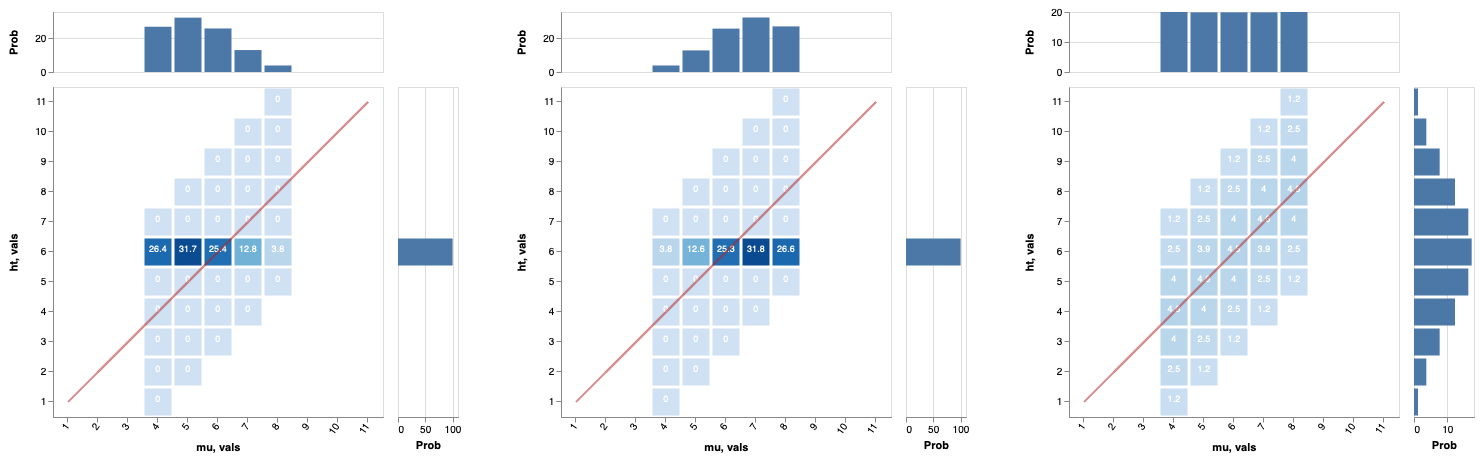

In [96]:
writeIORef cacheRefTall (0, Map.empty)
writeIORef cacheRefShrt (0, Map.empty)
writeIORef cacheRefNone (0, Map.empty)

mkGraph m = do
  heat <- enumD (first ht <$> m)
  return $ margHeatFromDist heat
--   bar  <- enumD (lexID    . snd <$> m)
--   return $ toVegaLite
--     [ center True
--     , vConcat [fromVL (margHeatFromDist heat), fromVL (sdBarFromDist sigma bar)]
--     ]
    
vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoQFDem cacheRefTall (1, UTall, 6)
  , listener infoQFDem cacheRefShrt (1, UShrt, 6)
  , listener infoQFDem cacheRefNone (1, UNone, 6)
  ]